# SEP Forecasting 
***

Current physics based models of SEPs are unable to execute sufficiently fast in order to
provide actionable information towards forecasting such disturbances, which can impact
Earth within tens of minutes of the onset of an eruptive event. This is compounded by
the intrinsic latency of certain key observations, which are used to define the initial
conditions of these models. Instead, there is a reliance on statistical models to provide
forecast probabilities of Earth-bound SEPs using real-time data. Since the largest, most
impactful events occur infrequently, some regions of the feature space are sparse and
simple discrete binning procedures have limitations. The goal of this project is to
improve upon the empirical SEP proton prediction forecast model (PROTONS) currently
in operational use at SWPC, through the application of modern machine learning
techniques.

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

from pandas.plotting import scatter_matrix

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from scipy.sparse import csr_matrix, find









#### Reading in the SEP and control data

In [7]:
#read in the Balch SEP event list
sepdata = pd.read_excel("SPEall.v7p.xls")

#read in the Balch SEP event list
ctrldata = pd.read_excel("ctrlevents.v8p.xls")

In [41]:
list(sepdata)

['Onset',
 'Threshold',
 'Maxtime',
 'Maxflux',
 'Endtime',
 'EPSSatId',
 'FlrOnset',
 'Flrmaxtime',
 'Flrendtime',
 'FlrPeakFlux',
 'xrscls',
 'ocls',
 'optlocation',
 'region',
 'TypeII',
 'TII_Duration',
 'TypeIV',
 'TIV_duration',
 'CME_speed',
 'XRSSatId',
 'FlrHpTime',
 'FlrIntFlux',
 'FlrIntFlux2',
 'P10MAX',
 'P30MAX',
 'P60MAX',
 'P100MAX',
 'P10FLUENCE',
 'P30FLUENCE',
 'P60FLUENCE',
 'P100FLUENCE']

#### Make Scatterplot matrix showing relationship between parameters

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2fc1f1d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a34c717f0>]], dtype=object)

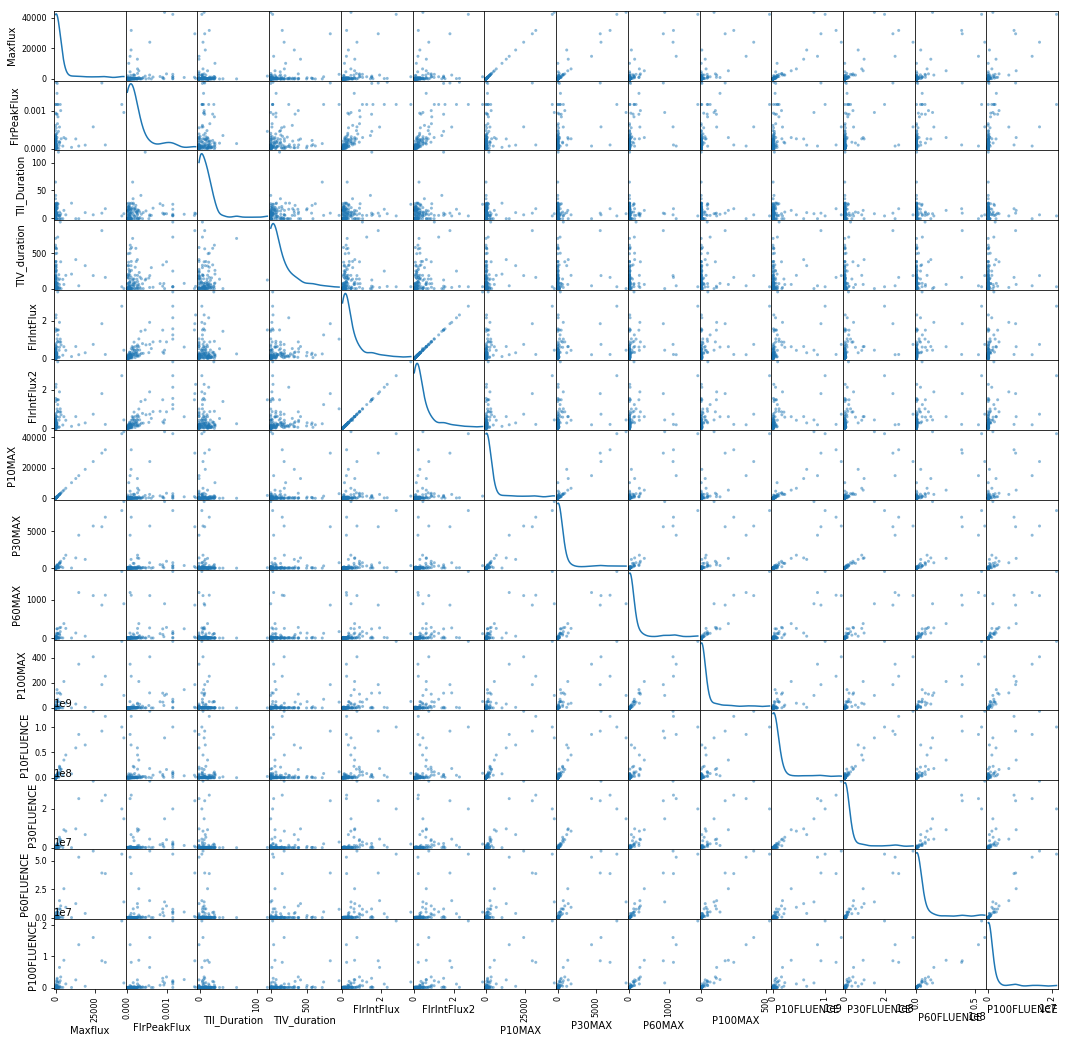

In [37]:
pd.plotting.scatter_matrix(sepdata[['Maxflux','FlrPeakFlux','TII_Duration','TIV_duration',\
                            'FlrIntFlux','FlrIntFlux2','P10MAX','P30MAX','P60MAX',\
                            'P100MAX','P10FLUENCE','P30FLUENCE','P60FLUENCE','P100FLUENCE']], \
                            figsize=(18,18), diagonal='kde')

### Logisitic Regression

#### Class to exract features from dataframe that can be used directly

In [45]:
class RawFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        
        return None
    
    def fit(self, examples):
        # return self and nothing else 
        return self
    
    def get_feature_names(self):
        """Array mapping from feature integer indices to feature name"""
        
        return ["FlTim2Pk"]
    
    def transform(self, examples):
        
        # Initiaize matrix 
        X = np.zeros((len(examples),1))           
        
        ## TODO
        
        #time between flare max and flare onset
        #X[ii,:] = examples.Flrmaxtime - examples.FlrOnset
        
        return(X)

#### Class to create feature with the time between flare onset to flare max time

In [43]:

class FlareTime2Peak(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        
        return None
    
    def fit(self, examples):
        # return self and nothing else 
        return self
    
    def get_feature_names(self):
        """Array mapping from feature integer indices to feature name"""
        
        return ["FlTim2Pk"]
    
    def transform(self, examples):
        
        # Initiaize matrix 
        X = np.zeros((len(examples),1))           
        
        #time between flare max and flare onset
        X[ii,:] = examples.Flrmaxtime - examples.FlrOnset
        
        return(X)

In [44]:
class SEP:
    def __init__(self, ngrams_max=2, min_df=1, max_df=1.0, binary=False, use_idf=True, \
                 tfidf_norm='l2', max_feat=None, stop_words=None, vocab=None, sublinear = True, clean_data = True, grammar_remove = False):
        
        from sklearn.feature_extraction.text import CountVectorizer
        
        self.clean_data = clean_data               #flag to turn data cleaning on and off
        self.grammar_remove = grammar_remove       #flag to turn feature dropping based on grammar on and off
        

        #Set up the Feature union to combine Feature creating classes
        self.allmyfeatures = FeatureUnion([
            #("tfidf_countvec", TfidfVectorizer(stop_words = stop_words, tokenizer = LemmaTokenizer(), ngram_range=(1, ngrams_max),\
            #                                min_df = min_df, max_df = max_df, binary = binary, use_idf = use_idf,\
                                            norm = tfidf_norm, max_features = max_feat, sublinear_tf=sublinear, vocabulary=vocab)),
            ("FlareTime2Peak", FlareTime2Peak()),
            ("RawFeat", RawFeatures()),
            ])


    
    def build_train_features(self, examples):
        """
        Method to take in training text features and do further feature engineering 
        Most of the work in this homework will go here, or in similar functions  
        :param examples: currently just a list of forum posts  
        """  
        
        return self.allmyfeatures.fit_transform(self.clean_examples)
        

    def get_test_features(self, examples):
        """
        Method to take in test text features and transform the same way as train features 
        :param examples: currently just a list of forum posts  
        """
    
        return self.allmyfeatures.transform(examples)

    def show_topX(self, num=3):
        """
        prints the top num features for the positive class and the 
        top 10 features for the negative class. 
        """
        feature_names = np.asarray([x.split("__")[1] for x in self.allmyfeatures.get_feature_names()])
        topX = np.argsort(self.logreg.coef_[0])[-num:]
        bottomX = np.argsort(self.logreg.coef_[0])[:num]
        
        print("\nTop 3 features for Pos and Neg\n-------------------------")
        for fn in np.arange(1,num):
            print("Pos %i: %s %f" % (fn, feature_names[topX[-fn]], self.logreg.coef_[0,topX[-fn]]))
        for fn in np.arange(0,num-1):
            print("Neg %i: %s %f" % (fn, feature_names[bottomX[fn]], self.logreg.coef_[0,bottomX[fn]]))

      
    def show_misclassified(self):     

        """
        Method to show the misclassified examples i.e. False Positives and False negatives 
        """
        
        #get all the feature names
        words = feat.allmyfeatures.get_feature_names()
        
        # False positives
        print("\nSome misclassified examples:")
        falsepos = np.where((self.train_pred != self.y_train) & (self.train_pred == 1))[0]   #all false pos example rows
        print("\nPredicted SEP but labeled AllClear (False Pos) \n------------------------- ")

        for i in range(len(falsepos[0:10])):         #loop through falsepos examples
            weights_falsepos = []
            x = find(feat.X_train[falsepos[i]])      #find which features are used for this example
            for ii in x[1]:                          #from sparse matrix get column indices corresponding to features
                weights_falsepos.append((words[ii].split('__')[1], self.logreg.coef_[0,ii]))      #get the word and weight

            print("label: %i, prediction %i, Neg Prob: %f, Pos Prob: %f, Ex No.: %i,  example: %s " % \
                (self.y_train[falsepos[i]], self.train_pred[falsepos[i]] , self.train_pred_prob[falsepos[i]][0], \
                     self.train_pred_prob[falsepos[i]][1], falsepos[i], self.clean_examples[falsepos[i]]))
            for j in weights_falsepos:
                print(j)
                
        # False Negatives
        falseneg = np.where((self.train_pred != self.y_train) & (self.train_pred == 0))[0]
        print("\nPredicted AllClear but labeled SEP (False Neg) \n-------------------------")

        for i in range(len(falseneg[0:10])):
            weights_falseneg = []
            x = find(feat.X_train[falseneg[r]])
            for ii in x[1]:
                weights_falseneg.append((words[ii].split('__')[1], self.logreg.coef_[0,ii])) 

            print("label: %i, prediction %i, Neg Prob: %f, Pos Prob: %f, Ex No.: %i, \nexample: %s " % \
                (self.y_train[falseneg[i]], self.train_pred[falseneg[i]], self.train_pred_prob[falseneg[i]][0], \
                 self.train_pred_prob[falseneg[i]][1], falseneg[i], self.clean_examples[falseneg[i]]))
            for j in weights_falseneg:
                print(j)
        
        print("\n\n")
       

    def score(self, predictions, y, dfTrain):

        """find the accuracy score given the labels and the predictions"""
        
        print("Accuracy: %f" % accuracy_score(y, predictions))


    def train_model(self, random_state=1234):
        """
        Method to read in training data from file, and 
        train Logistic Regression classifier. 
        
        :param random_state: seed for random number generator 
        """
        
        from sklearn.linear_model import LogisticRegression 
        
        # load data 
        self.dfTrain = pd.read_csv("../data/spoilers/train.csv")
                      
        # get training features and labels 
        self.X_train = self.build_train_features(list(self.dfTrain["sentence"][0::]))    #CHANGE
        self.y_train = np.array(self.dfTrain["spoiler"][0::], dtype=int)
        
        #print the shape of the features
        print("Shape of the Features: Num examples x Num Features")
        print(self.X_train.shape)
        
        # train logistic regression model.  !!You MAY NOT CHANGE THIS!! 
        self.logreg = LogisticRegression(random_state=random_state)
        self.logreg.fit(self.X_train, self.y_train)

        # make predictions on training data 
        self.train_pred = self.logreg.predict(self.X_train)

        #return the LogReg probabilities used to classify each example  
        self.train_pred_prob = self.logreg.predict_proba(self.X_train)
        
        print("\nTraining Set\n-------------------------")
        self.score(self.train_pred, self.y_train, self.dfTrain)
             
        #cross validation
        folds = 2
        
        print("\nCross Validation Accuracy Scores (cross_val_score)\n-------------------------")
        scores = cross_val_score(self.logreg, self.X_train, self.y_train, cv=folds)
        print(scores)
        print("\nMean Accuracy in Cross-Validation = %.3f \n" % scores.mean())
        
        #cross validation
        print("\nCross Validation Accuracy Scores (cross_val_predict)\n-------------------------")
        self.y_pred = cross_val_predict(self.logreg, self.X_train, self.y_train, cv=folds)
        print(self.score(self.y_pred, self.y_train, self.X_train))
        
        print("\nCross Confusion Matrix\n-------------------------")
        self.conf_mat = confusion_matrix(self.y_train,self.y_pred)
        tn, fp, fn, tp = self.conf_mat.ravel()
        print("True Pos: %i, True Neg: %i, False Pos: %i,. False Neg: %i" % (tp,tn,fp,fn))
        
          
        
    def model_predict(self):
        """
        Method to read in test data from file, make predictions
        using trained model, and dump results to file 
        """
        
        # read in test data 
        dfTest  = pd.read_csv("../data/spoilers/test.csv")
        
        # featurize test data 
        self.X_test = self.get_test_features(list(dfTest["sentence"]))
        
        # make predictions on test data 
        pred = self.logreg.predict(self.X_test)
        
        # dump predictions to file for submission to Kaggle  
        pd.DataFrame({"spoiler": np.array(pred, dtype=bool)}).to_csv("prediction.csv", index=True, index_label="Id")
        
                

I added something!!

Hazel added something else

TEsting another cell

Eric added again

C'mon Eric get it together